# Diagnosing model performance

## State-of-the-art
- evaluation of model performance to quantify the prediction skill
- well-established performance metrics like KGE and NSE
- number between $-\infty$ and 1, but these numbers only provide limited insights into model perfomance
- if my model performance is bad: where do the errors come from? What processes might not be captured by the model?

## Objectives
- Objective: Diagnosing model performance by introducing a novel efficiency measure based on flow duration curve.
- Flow duration curve covers different processes (e.g. runoff generation, storage recession)

This notebook demonstrates the usage of DE and provides a proof of concept.

### Data
We use observed streamflow data from the river Pfinz, Germany, which is located in the file examples/data/9960682_Q_1970_2012.csv.

In [1]:
import datetime as dt
import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy as sp
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})  # controlling figure aesthetics
import de

First, we import a daily observed streamflow time series and plot the time series:

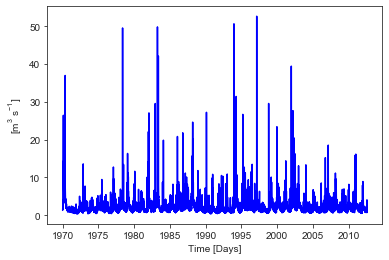

In [2]:
# Import a function that deals with paths properly, regardless of OS
from pathlib import Path  

path = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/data/9960682_Q_1970_2012.csv')
df_ts = de.import_ts(path, sep=';') # import observed time series
de.plot_ts(df_ts)

Here we introduce the novel Diagnostic-Efficiency (DE):

### Diagnostic-Efficieny (DE)
$DE = 1 - \sqrt{B_{Bal}^2 + B_{Slope}^2 + (r - 1)^2}$   (1)

Eqs. (2) - (5) are use observed values ($Q_{obs}$) and simulated values ($Q_{sim}$) which are sorted by descending order.

#### Relative Bias ($B_{rel}$)
$B_{rel}(i) = \frac{(Q_{sim}(i) - Q_{obs}(i))}{Q_{obs}(i)}$   (2)
i represents the exceedence probability.

#### Arithmetic mean of relative bias
$B_{bal} = \frac{1}{N}\sum_{i=1}^{N} B_{rel}(i)$   (3)
Value within a range of $-\infty$ to $-\infty$ reflects the balance of relative biases. Positive values indicate that the model consistently overestimates (e.g. input surpluses propagate into the model) whereas negative values suggest consistent underestimation by the model (e.g. input shortages propagate into the model). This metric component reflects best errors in the input data.

#### Linear regression for relative bias
$B_{rel}(i) = y + bi$   (4)

#### Slope of linear regression ($B_{Slope}$) derived from Eq. (4)
$B_{slope} = b*100$   (5)
Value represents inclination of relative biases. The range goes from $-\infty$ to $-\infty$. Positive values indicates that the model underestimate high flows and overstimate low flows (i.e. storages are filled to quickly and release water too slowly). By contrast, negative values describe overestimation of high flows and underestimation of low flows by the model (i.e. storages implemented in the model releas water too quickly). This metric component reflects best errors caused by the model structure/parametrization.

#### Spearmans rank correlation (r) between $Q_{sim}$ and $Q_{obs}$
Equation???    (6)
r represents the temporal correlation between $Q_{sim}$ and $Q_{obs}$ which ranges between 1 and -1.

We compare the DE to the commonly used Kling-Gupta-Efficiency (KGE) and Nash-Sutcliffe-Efficiency (NSE). 

### Kling-Gupta-Efficiency (KGE)
$KGE = 1 - \sqrt{(\frac{\gamma - 1)^2 + (\frac{\beta - 1)^2 + (r - 1)^2}$   (6)
$KGE = 1 - \sqrt{(\frac{\gamma_{sim}}{\gamma_{obs}} - 1)^2 + (\frac{CV_{sim}}{CV_{obs}} - 1)^2 + (r - 1)^2}$   (6)

### Nash-Sutcliffe-Efficiency (NSE)
$NSE = 1 - \frac{\sum_{t=1}^{t=T} (Q_{sim}(t) - Q_{obs}(t))^2}{\sum_{t=1}^{t=T} (Q_{obs}(t) - \overline{Q_{obs}})^2}$    (7)

### 2-D plots of DE and KGE
Since DE and KGE consists of three components (see Eqs. (1) and (6)), the components can be visulaized in a 2D-space.  The three components biuld up originally a 3D-space, but can be reduced to a 2D-space by representing the temporal component (r) assigning a color. In the following we show two examples for the cases $DE = 1$ and $KGE = 1$.

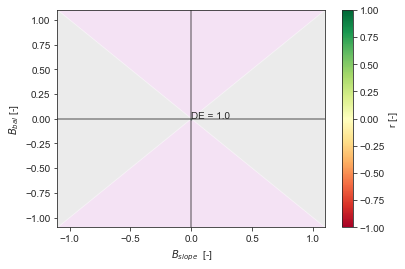

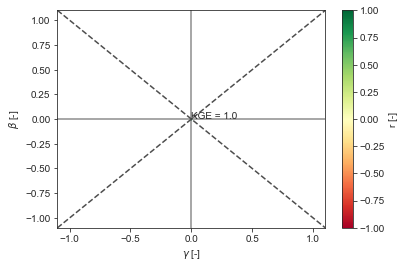

In [3]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = df_ts.loc[:, 'Qobs']  # observedtime series

# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

The upper figure shows the visualitazion of the DE in the 2D-space. We call it the hydrologic modeling clock. The shorter the lenght of the hand and the greener the error the better is the model performance. By contrast, the longer the hand the worse performs the model. The shaded regions are used to identify where the error comes from. Regions are colorized purple if $B_{bal}$ is greater than $B_{slope}$. Thus, the origin of errors comes from input data. For greyish regions, $B_{bal}$ is less than $B_{slope}$ which means that the origin of errors is linked to the model itself.

For comparison, we display the KGE in the 2D-space. In contrast to the DE, the 2D-plot does not allow to distinguish between the origin of errors.

### Proof of concept
In order to mimick model errors or input data errors, respectively, we manipulate the observed time series:
1. Mimicking model errors
2. Mimicking input data errors
3. Combination of 1. and 2.
3. Mean flow benchmark

### 1. Mimicking model errors

#### Increase high flows - Decrease low flows

We generate a new by time series by increasing high flows and decreasing low flows. In particular we tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in steeper gradient of the flow duration curve (red curve).

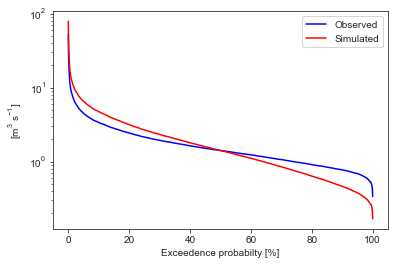

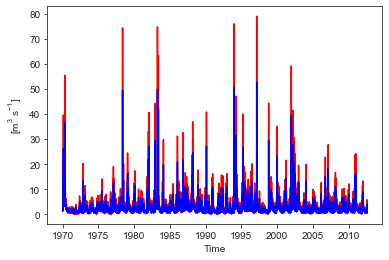

In [4]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # disaggregated time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

We calculate DE, KGE and NSE. DE and KGE are plotted in 2D-space.

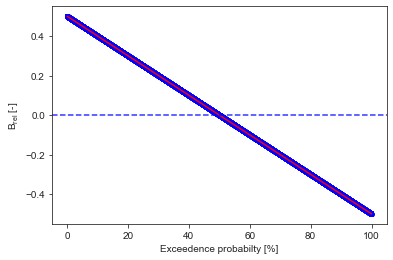

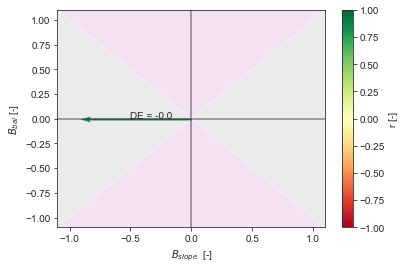

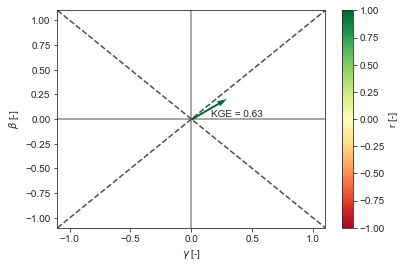

In [5]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [6]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.0
KGE: 0.63
NSE: 0.65


The upper figure shows the result for the linear regression for relativa Biases.

The figure in the middle represents the visualisation of the DE in the 2D-space which gives evidence that the model structure/parameterisation is deficient resulting in a DE which is 0.

The lower figure represents the KGE in a 2D-space.

#### Decrease high flows - Increase low flows

We generate a new by time series by decreasing high flows and increasing low flows. We tilt the flow duration curve around the median value (i.e. $Q_{50}$). This results in a flatter gradient of the flow duration curve (red curve).

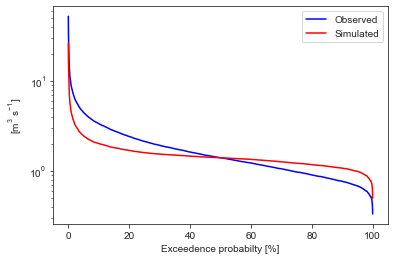

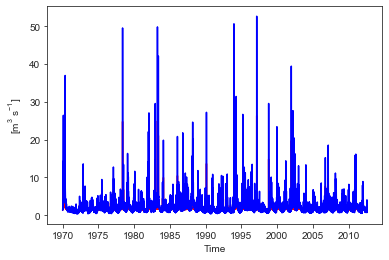

In [7]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)
obs_sim.loc[:, 'Qsim'] = tsd.loc[:, 'Qsim']  # smoothed time series
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

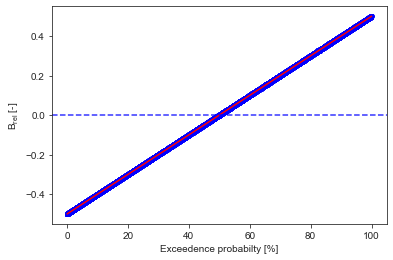

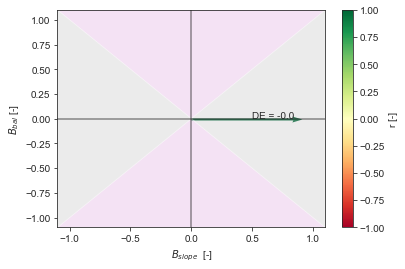

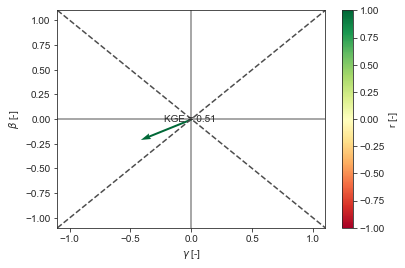

In [8]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [9]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.0
KGE: 0.51
NSE: 0.65


### 2. Mimicking input data errors

#### Precipitation surplus

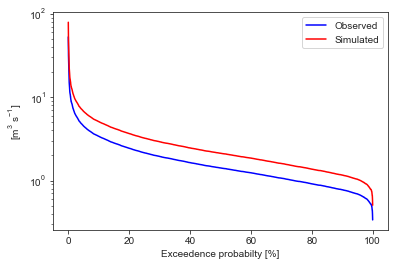

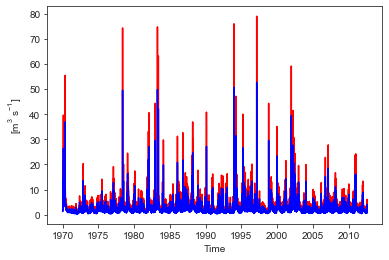

In [10]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(df_ts['Qobs'].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

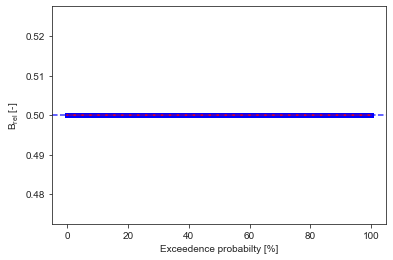

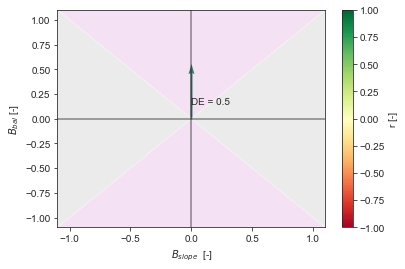

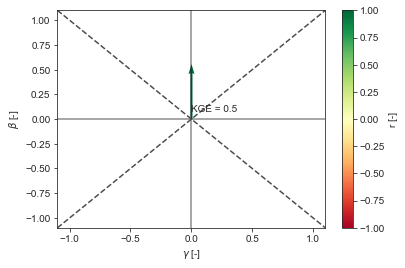

In [11]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

#### Precipitation shortage

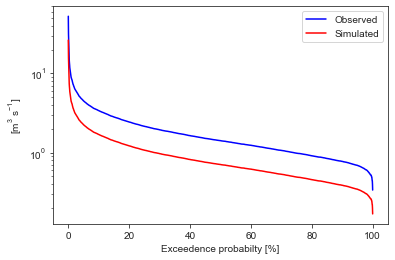

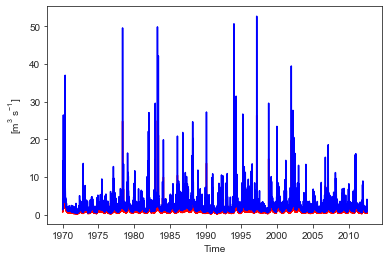

In [12]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(df_ts['Qobs'].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

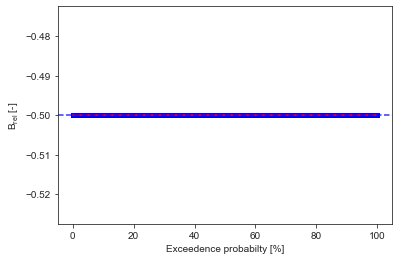

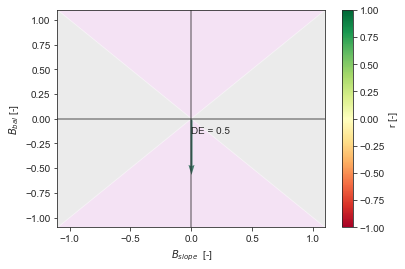

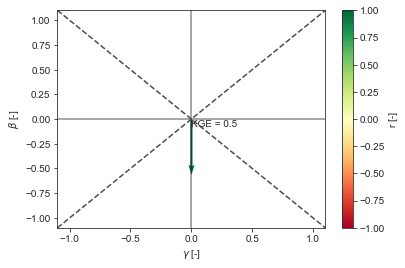

In [13]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

### Combination of 1. and 2.

#### Decrease high flows - Increase low flows and precipitation surplus

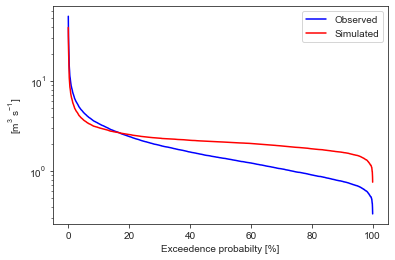

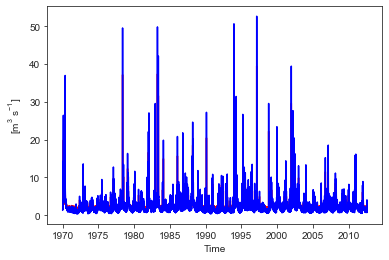

In [14]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(tsd.iloc[:, 0].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

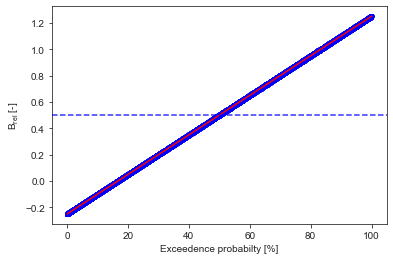

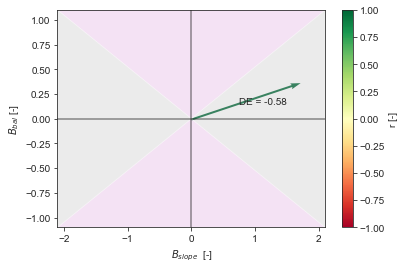

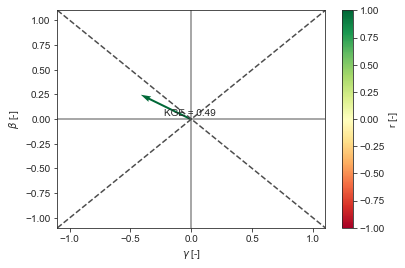

In [15]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [16]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.58
KGE: 0.49
NSE: 0.83


#### Decrease high flows - Increase low flows and precipitation shortage

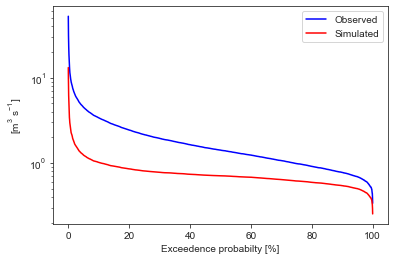

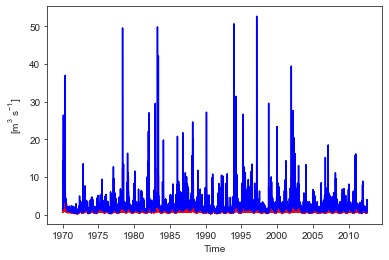

In [17]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highunder_lowover(df_ts.copy(), prop=0.5)  # smoothed time series
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(tsd.iloc[:, 0].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

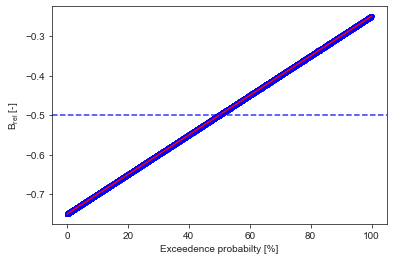

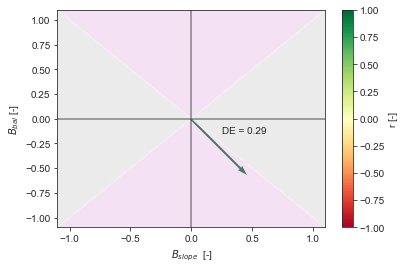

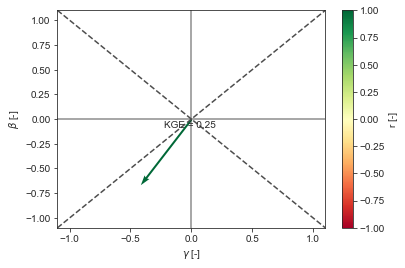

In [18]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [19]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.29
KGE: 0.25
NSE: 0.08


#### Increase high flows - Decrease low flows and precipitation surplus

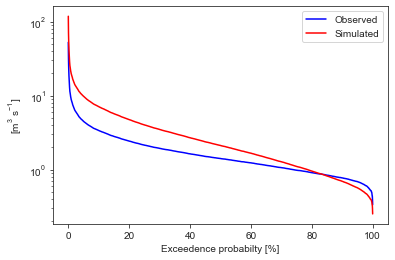

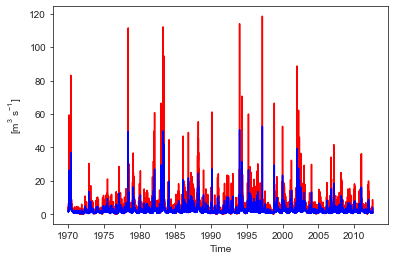

In [20]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5)  # disaggregated time series
obs_sim.loc[:, 'Qsim'] = de.pos_shift_ts(tsd.iloc[:, 0].values)  # positive offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

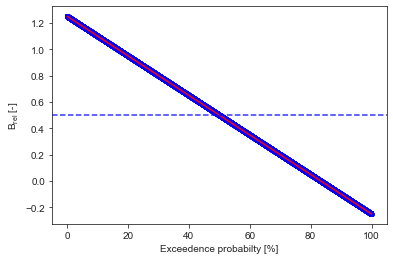

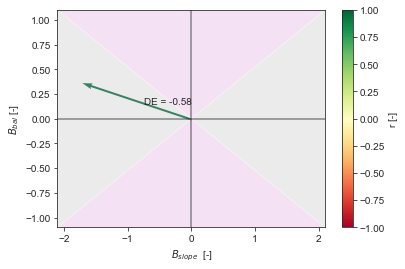

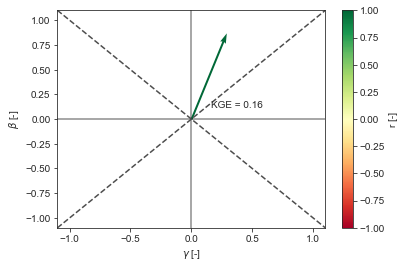

In [21]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [22]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -0.58
KGE: 0.16
NSE: -1.34


#### Increase high flows - Decrease low flows and precipitation shortage

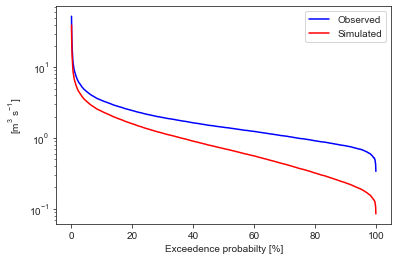

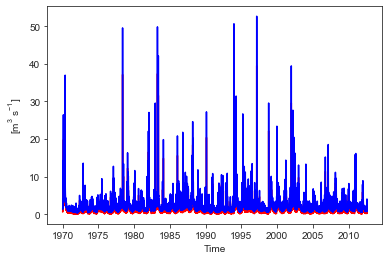

In [23]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
tsd = de.highover_lowunder(df_ts.copy(), prop=0.5) # disaggregated time series
obs_sim.loc[:, 'Qsim'] = de.neg_shift_ts(tsd.iloc[:, 0].values)  # negative offset
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

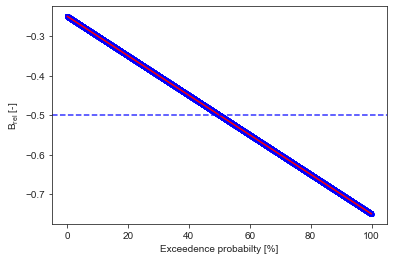

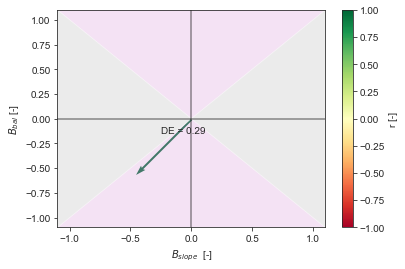

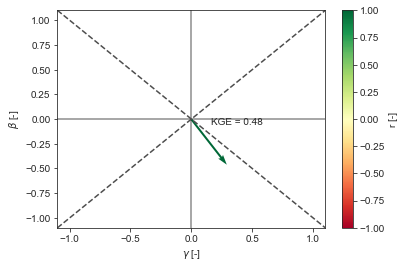

In [24]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [25]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.29
KGE: 0.48
NSE: 0.8


### Mean flow benchmark

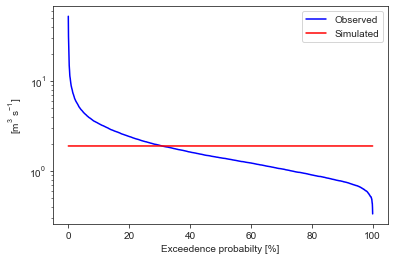

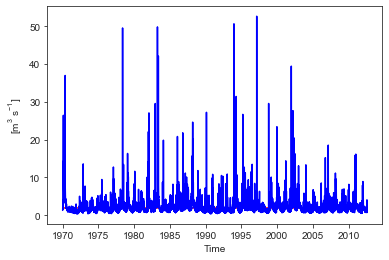

In [26]:
obs_sim = pd.DataFrame(index=df_ts.index, columns=['Qobs', 'Qsim'])
obs_sim.loc[:, 'Qobs'] = df_ts.loc[:, 'Qobs']
obs_mean = np.mean(obs_sim['Qobs'].values)
obs_sim.loc[:, 'Qsim'] = np.repeat(obs_mean, len(obs_sim['Qobs'].values))
de.fdc_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])
de.plot_obs_sim(obs_sim['Qobs'], obs_sim['Qsim'])

/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/Users/robinschwemmle/anaconda3/envs/de/lib/python3.7/site-package

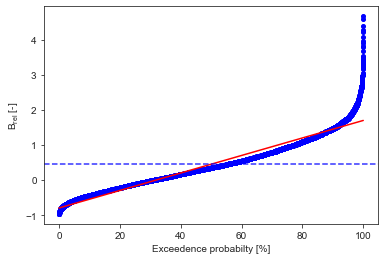

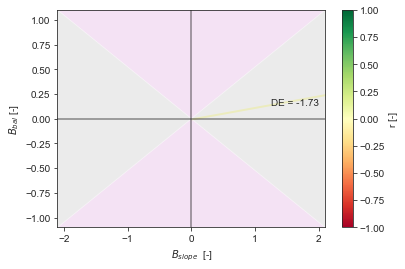

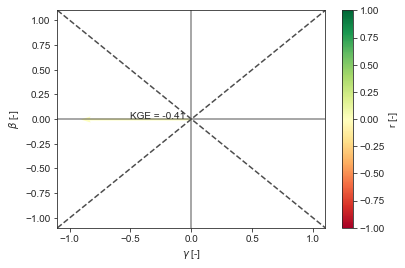

In [27]:
# make numpy arrays
obs_arr = obs_sim['Qobs'].values  # observed time series
sim_arr = obs_sim['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [28]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: -1.73
KGE: -0.41
NSE: 0.0


###  Real case example (eartH2Observe Tier-2)

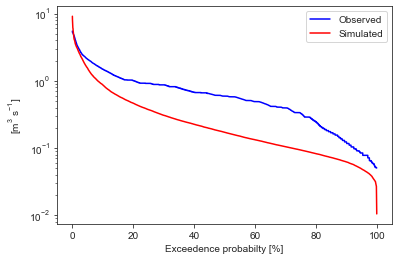

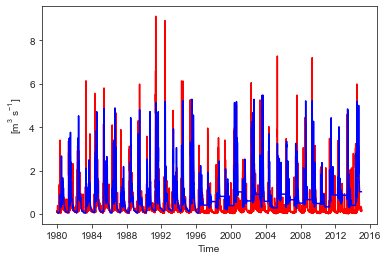

In [29]:
path_wrr2 = Path('/Users/robinschwemmle/Desktop/PhD/diagnostic_model_efficiency/examples/data/GRDC_4103631_wrr2.csv')
df_wrr2 = de.import_ts(path_wrr2, sep=';') # import time series
de.fdc_obs_sim(df_wrr2['Qobs'], df_wrr2['Qsim'])
de.plot_obs_sim(df_wrr2['Qobs'], df_wrr2['Qsim'])

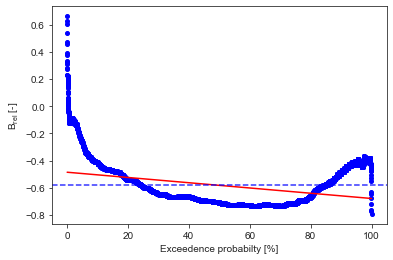

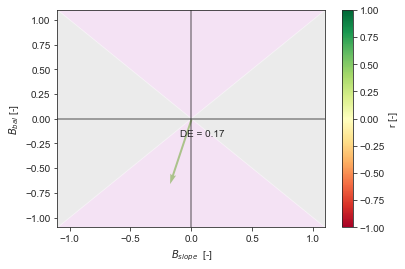

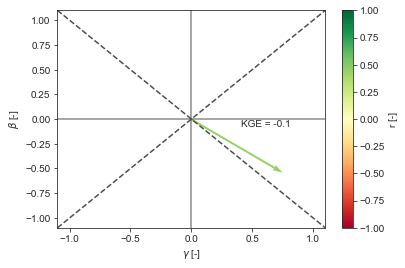

In [30]:
# make numpy arrays
obs_arr = df_wrr2['Qobs'].values  # observed time series
sim_arr = df_wrr2['Qsim'].values  # simulated time series

sig_de = de.calc_de(obs_arr, sim_arr)  # Diagnostic-Efficiency 
sig_kge = de.calc_kge(obs_arr, sim_arr) # Kling-Gupta-Efficiency
sig_nse = de.calc_nse(obs_arr, sim_arr)  # Nash-Sutcliffe-Efficiency

de.vis2d_de(obs_arr, sim_arr)  # 2-D plot of Diagnostic efficiency 
de.vis2d_kge(obs_arr, sim_arr)  # 2-D plot of Kling-Gupta efficiency

In [31]:
# print NSE on the screen
str_sig_de = 'DE: {}'.format(np.round(sig_de, decimals=2))
print(str_sig_de)

# print NSE on the screen
str_sig_kge = 'KGE: {}'.format(np.round(sig_kge, decimals=2))
print(str_sig_kge)

# print NSE on the screen
str_sig_nse = 'NSE: {}'.format(np.round(sig_nse, decimals=2))
print(str_sig_nse)

DE: 0.17
KGE: -0.1
NSE: -0.48


### Conclusions

### References